In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio

from astropy import units as u
from astropy.coordinates import SkyCoord

sys.path.append(os.path.expanduser("~")+'/git/Python/user_modules/')
from match_coord import search_around, scatter_plot, match_coord

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def relative_density_plot(d_ra, d_dec, d2d, search_radius, ref_density, nbins=101, vmin=-3, vmax=3, unit='arcsec'):
    bins = np.linspace(-search_radius, search_radius, nbins)
    bin_spacing = bins[1] - bins[0]
    bincenter = (bins[1:]+bins[:-1])/2
    mesh_ra, mesh_dec = np.meshgrid(bincenter, bincenter)
    mesh_d2d = np.sqrt(mesh_ra**2 + mesh_dec**2)
    mask = (d2d>2.)
    density, _, _ = np.histogram2d(d_ra[mask], d_dec[mask], bins=bins)/(bin_spacing**2)
    mask = mesh_d2d >= bins.max()-bin_spacing
    density[mask] = np.nan
    density_ratio = density/ref_density
    if unit=='arcsec':
        extent = bins.max()*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = bins.max()*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = bins.max()*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(density_ratio.transpose()-1, origin='lower', aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    return ax, bins, mesh_d2d, density_ratio

def relative_density_subplots(d_ra, d_dec, d2d, search_radius, ref_density, nbins=101, vmin=-3, vmax=3, unit='arcsec'):
    bins = np.linspace(-search_radius, search_radius, nbins)
    bin_spacing = bins[1] - bins[0]
    bincenter = (bins[1:]+bins[:-1])/2
    mesh_ra, mesh_dec = np.meshgrid(bincenter, bincenter)
    mesh_d2d = np.sqrt(mesh_ra**2 + mesh_dec**2)
    mask = (d2d>2.)
    density, _, _ = np.histogram2d(d_ra[mask], d_dec[mask], bins=bins)/(bin_spacing**2)
    mask = mesh_d2d >= bins.max()-bin_spacing
    density[mask] = np.nan
    density_ratio = density/ref_density
    if unit=='arcsec':
        extent = bins.max()*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = bins.max()*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = bins.max()*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    
    fig, ax = plt.subplots(1, 2, figsize=(17, 6.5))
    dens = ax[0].imshow(density_ratio.transpose()-1, origin='lower', aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    fig.colorbar(dens, ax=ax[0], fraction=0.046, pad=0.04)
    ax[0].axis(axis)
    ax[0].set_xlabel('$\Delta$RA (arcsec)')
    ax[0].set_ylabel('$\Delta$DEC (arcsec)')
    # plt.show()

    ax[1].plot(mesh_d2d.flatten(), density_ratio.flatten()-1, '.', markersize=1.5)
    # plt.axvline(mask_length1/2, lw=1, color='k')
    # plt.axvline(mask_length2/2, lw=1, color='k')
    ax[1].set_xlabel('distance (arcsec)')
    ax[1].set_ylabel('fractional overdensity')
    ax[1].grid(alpha=0.5)
    ax[1].axis([0, search_radius, -1, 6])
    
    return ax, bins, mesh_d2d, density_ratio

__0.37.0 target class maskbits: QSO: 0, ELG: 1, QSO: 2__   
https://github.com/desihub/desitarget/blob/0.37.0/py/desitarget/data/targetmask.yaml

In [4]:
target_bits = {'LRG':0, 'ELG':1, 'QSO':2}

In [5]:
target_path = '/global/cfs/cdirs/desi/target/catalogs/dr9sv/0.37.0/targets/main/resolve/dark/targets-dr9-hp-X.fits'
gaia_columns = ['RA', 'DEC', 'PHOT_G_MEAN_MAG']
target_columns = ['BRICKID', 'MORPHTYPE', 'RA', 'DEC', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'FLUX_W1', 'FLUX_W2', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'WISEMASK_W1', 'WISEMASK_W2', 'MASKBITS', 'PHOTSYS', 'DESI_TARGET']

---------------
## South

In [6]:
gaia_path = '/global/cscratch1/sd/rongpu/dr9dev/gaia_in_dr9sv/brightest_g_less_than_19_stars-dr9sv_south.fits'
region = b'S'
target_class = 'QSO'
target_bit = target_bits[target_class]

In [7]:
gaia = fitsio.read(gaia_path, columns=gaia_columns)
print(len(gaia))

cat = fitsio.read(target_path, columns=['DESI_TARGET', 'PHOTSYS'])
print(len(cat))
mask = ((cat["DESI_TARGET"] & (2**target_bit))!=0) & (cat['PHOTSYS']==region)
idx = np.where(mask)[0]
cat = fitsio.read(target_path, columns=target_columns, rows=idx)
cat = Table(cat)
print(len(cat))

7409227
5171874
137383


In [8]:
# Apply mask bits
mask = np.ones(len(cat), dtype=bool)
for bit in [1, 5, 6, 7, 11, 12, 13]:
        mask &= ((cat['MASKBITS'] & 2**bit) == 0)
print('{:} ({:.1f}%) objects removed due to maskbits'.format(np.sum(~mask), np.sum(~mask)/len(mask)*100))
cat = cat[mask]

3419 (2.5%) objects removed due to maskbits


In [9]:
Table(gaia[:1])

RA,DEC,PHOT_G_MEAN_MAG
float64,float64,float32
43.4586752951,2.05785431421,19.8332


In [10]:
cat[:1]

BRICKID,MORPHTYPE,RA,DEC,EBV,FLUX_G,FLUX_R,FLUX_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,NOBS_G,NOBS_R,NOBS_Z,FLUX_W1,FLUX_W2,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,WISEMASK_W1,WISEMASK_W2,MASKBITS,PHOTSYS,DESI_TARGET
int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,uint8,uint8,int16,bytes1,int64
501211,PSF,160.033495582,30.8965473195,0.0179216,1.16958,1.93758,2.13874,0.948331,0.964895,0.980209,4,3,4,2.89626,2.48948,0.996967,0.998137,0,0,0,S,262148


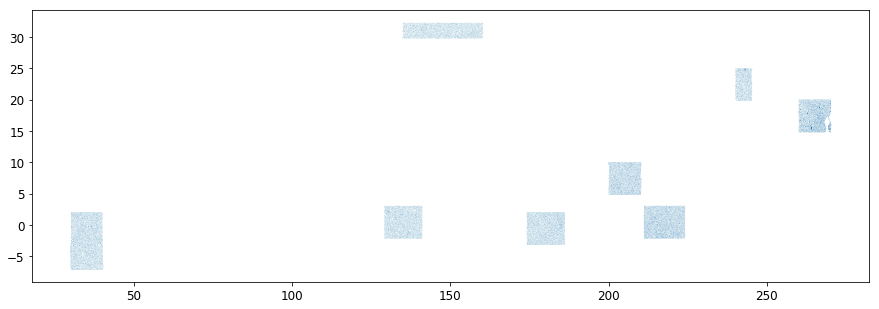

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.1, alpha=0.1)
plt.show()

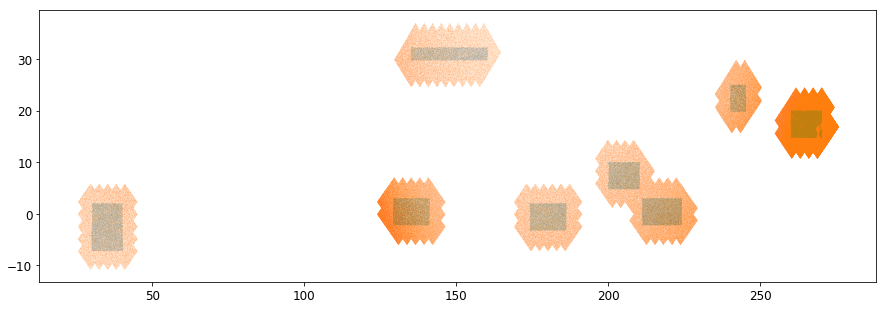

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.1, alpha=0.1)
plt.plot(gaia['RA'][::5], gaia['DEC'][::5], '.', ms=0.1, alpha=0.1)
# plt.axis([0, 360, -23, 40])
plt.show()

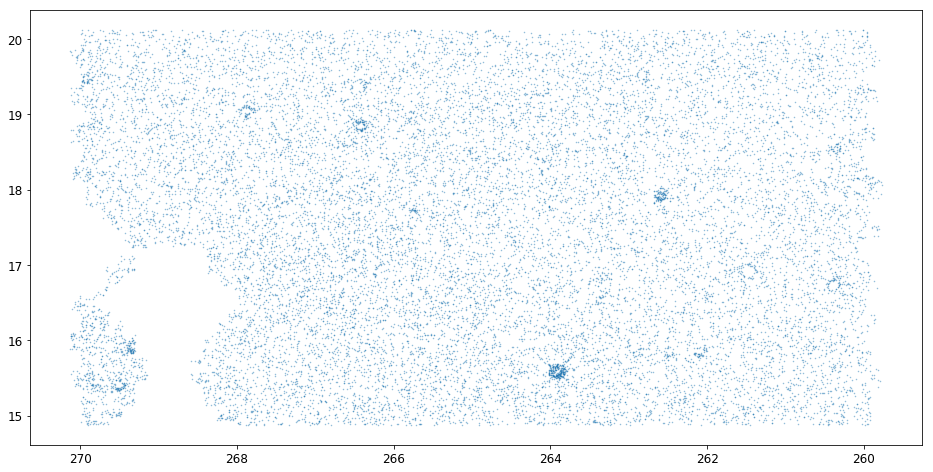

In [14]:
mask = cat['RA']>250
plt.figure(figsize=(16, 8))
plt.plot(cat['RA'][mask], cat['DEC'][mask], '.', ms=1, alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

In [15]:
mask = (gaia['PHOT_G_MEAN_MAG']>16) & (gaia['PHOT_G_MEAN_MAG']<17)
print(np.sum(mask), np.sum(mask)/len(mask))

ra1 = gaia['RA'][mask]
dec1 = gaia['DEC'][mask]
sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')

ra2 = cat['RA']
dec2 = cat['DEC']
sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')

754262 0.10180036325


14203 nearby objects


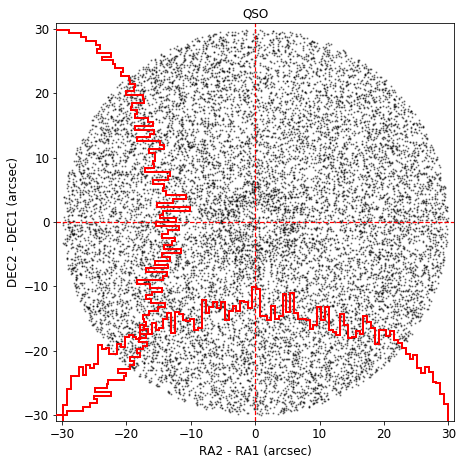

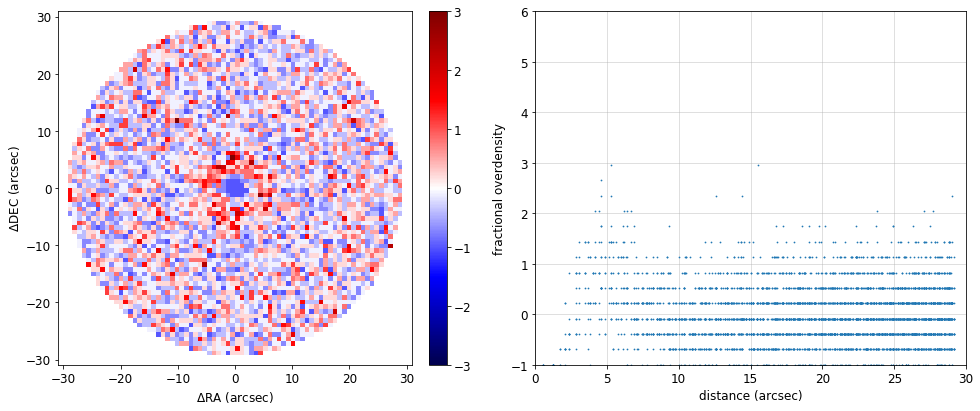

In [16]:
search_radius = 30.
# Paramater for estimating the overdensities
annulus_min = 25.
annulus_max = 30.

nbins = 75

idx1, idx2, d2d, _ = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
print('%d nearby objects'%len(idx1))

# convert distances to numpy array in arcsec
d2d = np.array(d2d.to(u.arcsec))

d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
# Convert d_ra to actual arcsecs
mask = d_ra > 180*3600
d_ra[mask] = d_ra[mask] - 360.*3600
mask = d_ra < -180*3600
d_ra[mask] = d_ra[mask] + 360.*3600
d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)

markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])    
axis = [-search_radius*1.03, search_radius*1.03, -search_radius*1.03, search_radius*1.03]
ax = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, title=target_class, show=False)
plt.show()

ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
ax, bins, mesh_d2d, density_ratio = relative_density_subplots(d_ra, d_dec, d2d, search_radius, ref_density=density_annulus, nbins=nbins)
plt.show()

__Visual inspection__

In [17]:
# mask = (d2d>5) & (d2d<7)
# mask &= cat['RA'][idx2]>250
# print(np.sum(mask))
# t = Table()
# t['RA'] = cat['RA'][idx2[mask]]
# t['DEC'] = cat['DEC'][idx2[mask]]
# t.write('/global/u2/r/rongpu/temp/visual_inspection.fits')

In [18]:
# mask = (d2d>5) & (d2d<7)
# tmp = idx2[mask]
# idx = np.random.choice(tmp, size=200, replace=False)
# t = Table()
# t['RA'] = cat['RA'][idx]
# t['DEC'] = cat['DEC'][idx]
# t.write('/global/u2/r/rongpu/temp/visual_inspection.txt', format='ascii.no_header')

__More plots!__

In [21]:
gaia_min_list = [-np.inf, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
gaia_max_list = [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
search_radius_list = [500, 350, 300, 250, 200, 150, 120, 90, 60, 30, 30, 30, 30, 30]

225 stars
1165 nearby objects


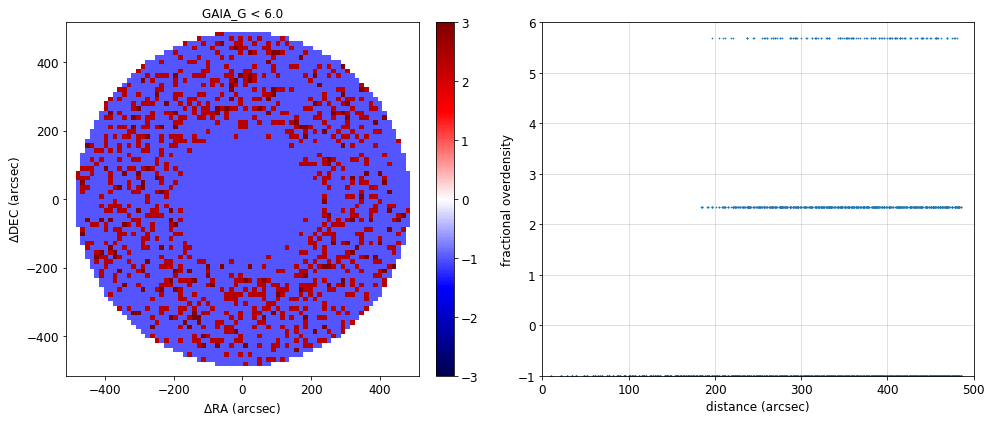

1666 stars
4218 nearby objects


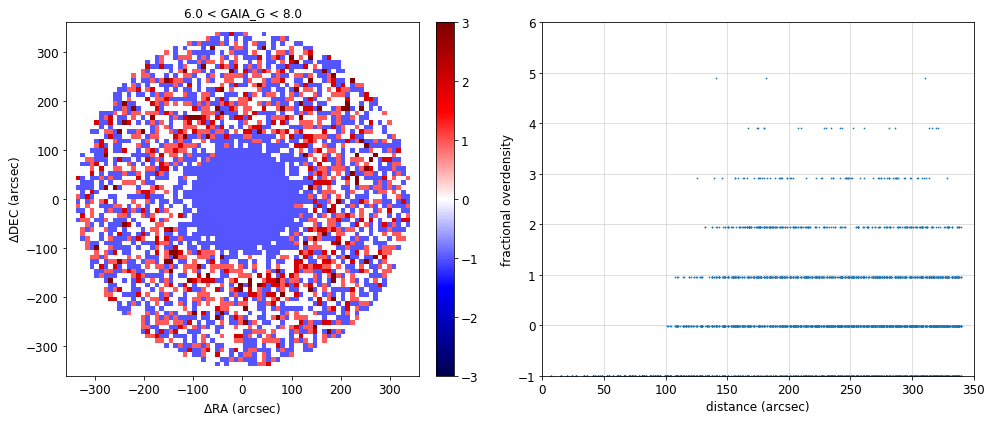

3026 stars
5054 nearby objects


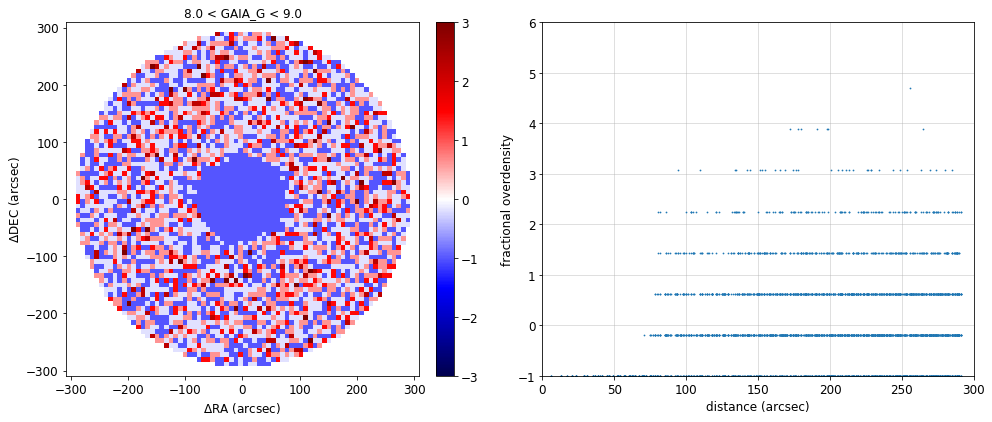

7251 stars
8933 nearby objects


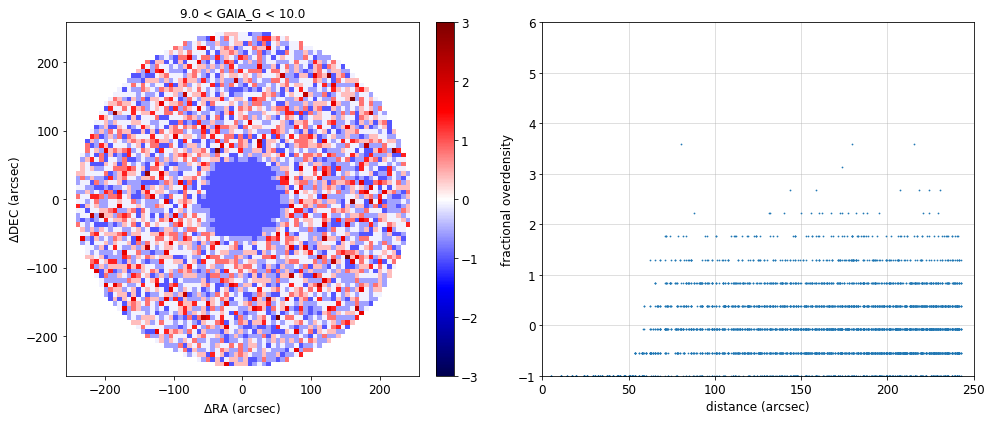

16437 stars
12504 nearby objects


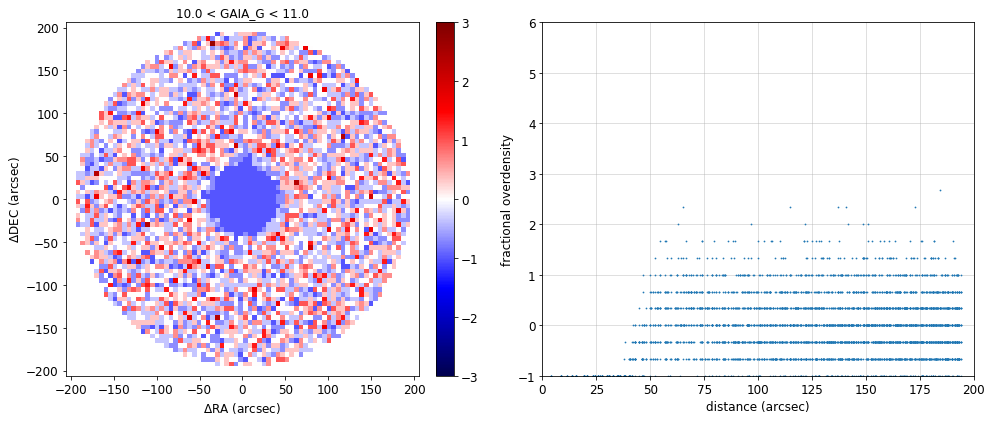

34776 stars
14739 nearby objects


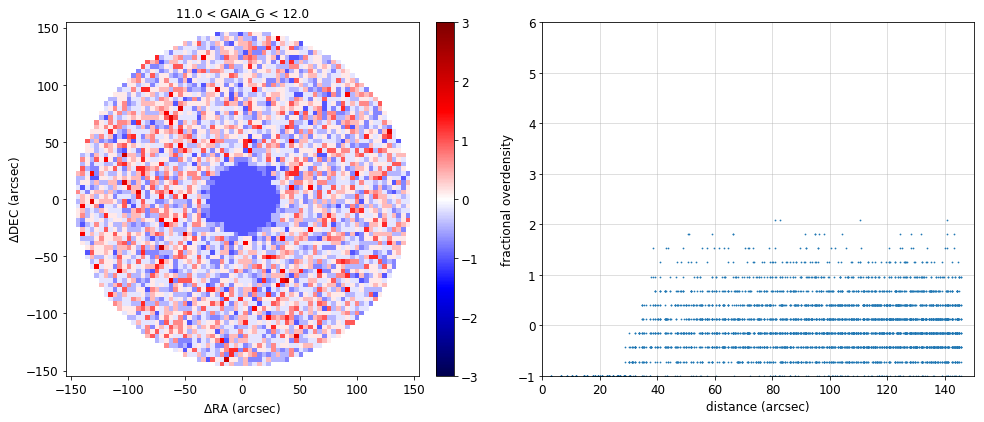

71322 stars
19897 nearby objects


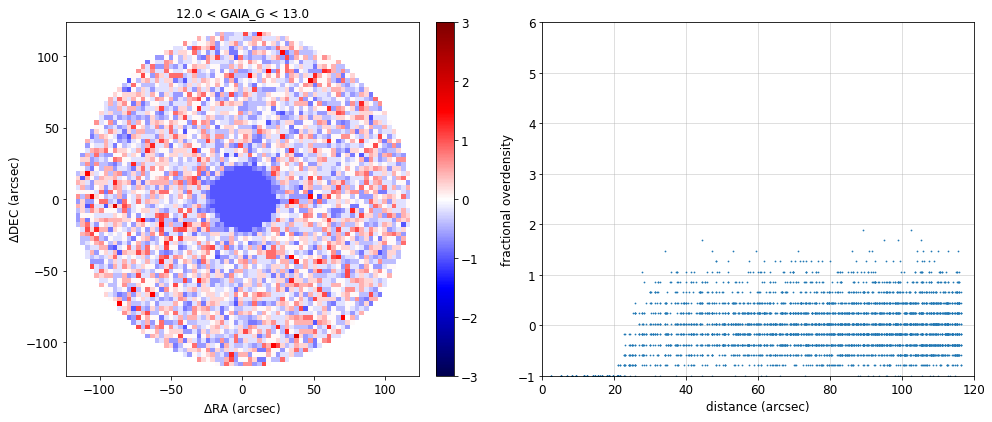

140909 stars
21819 nearby objects


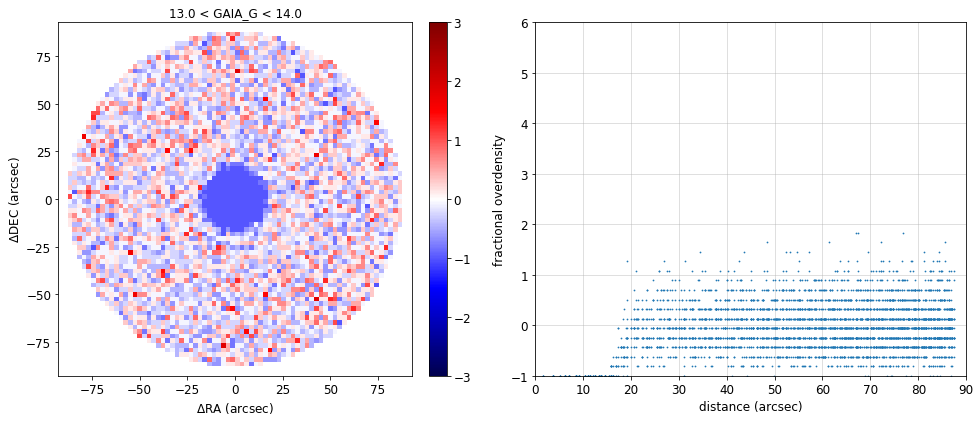

260670 stars
17773 nearby objects


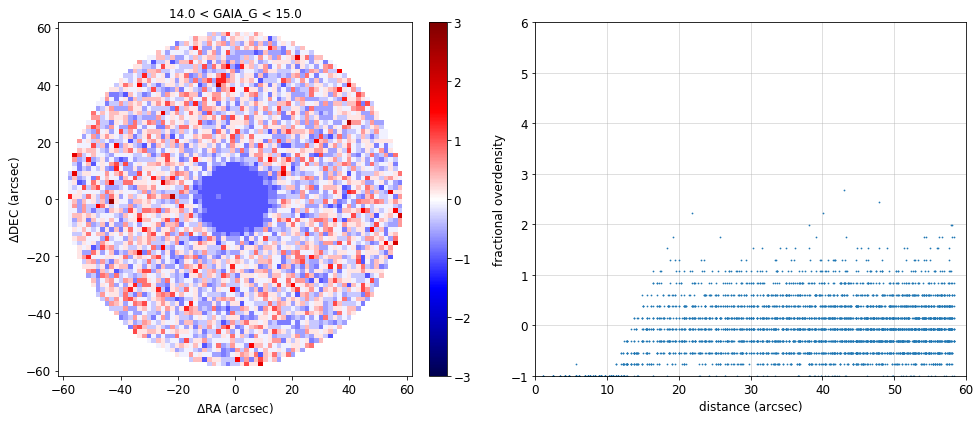

453566 stars
7291 nearby objects


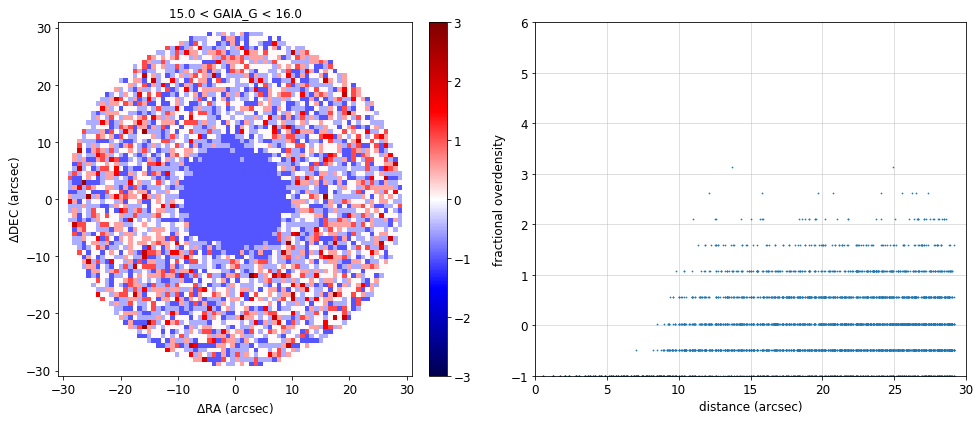

754262 stars
14203 nearby objects


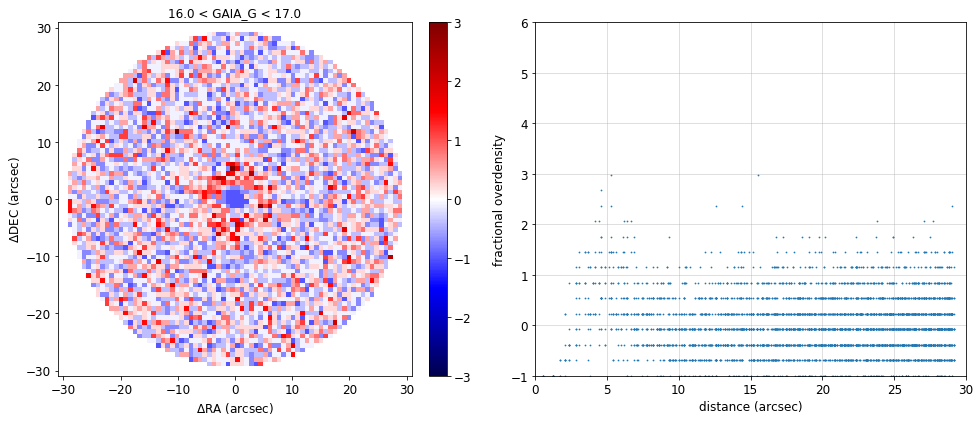

1197761 stars
22822 nearby objects


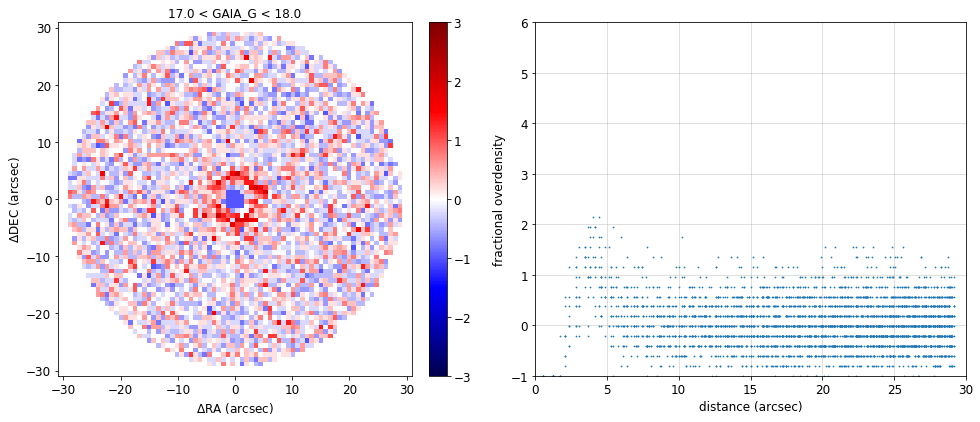

1810983 stars
36657 nearby objects


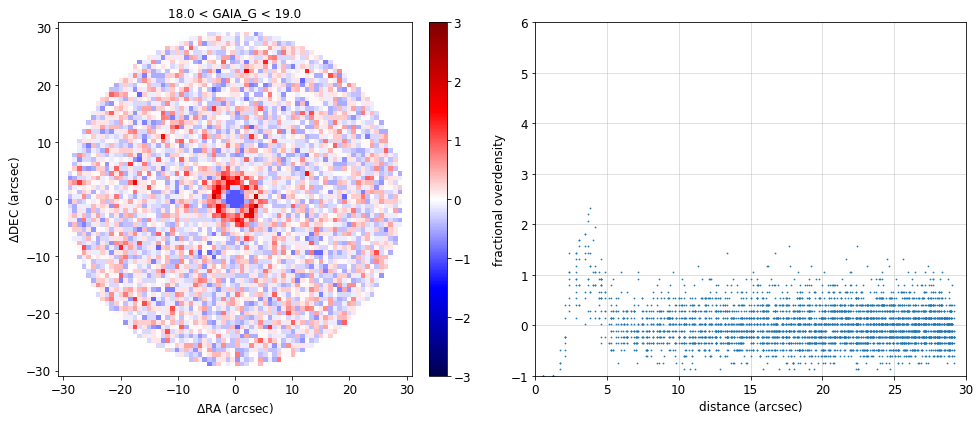

2656369 stars
59463 nearby objects


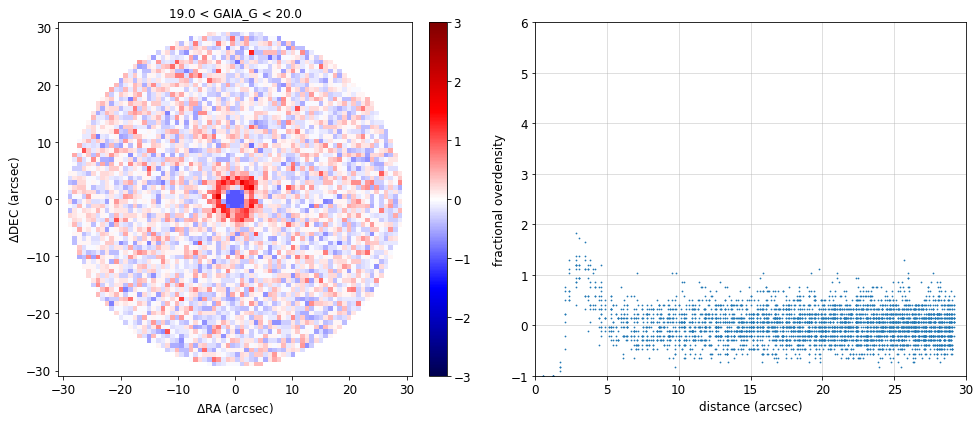

In [22]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('plots/QSO_DR9SV_South.pdf') as pdf:

    for index in range(len(gaia_min_list)):

        nbins = 75
        search_radius = search_radius_list[index]
        axis = [-search_radius*1.03, search_radius*1.03, -search_radius*1.03, search_radius*1.03]

        # Paramater for estimating the overdensities
        annulus_min, annulus_max = search_radius/3.*2, search_radius

        gaia_min, gaia_max = gaia_min_list[index], gaia_max_list[index]
        mask = (gaia['PHOT_G_MEAN_MAG']>gaia_min) & (gaia['PHOT_G_MEAN_MAG']<gaia_max)
        ra1 = gaia['RA'][mask]
        dec1 = gaia['DEC'][mask]
        if gaia_min==-np.inf:
            title = 'GAIA_G < {:.1f}'.format(gaia_max, np.sum(mask))
        else:
            title = '{:.1f} < GAIA_G < {:.1f}'.format(gaia_min, gaia_max, np.sum(mask))

        print('{} stars'.format(np.sum(mask)))

        sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
        idx1, idx2, d2d, _ = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
        print('%d nearby objects'%len(idx1))

        # convert distances to numpy array in arcsec
        d2d = np.array(d2d.to(u.arcsec))

        d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
        d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
        # Convert d_ra to actual arcsecs
        mask = d_ra > 180*3600
        d_ra[mask] = d_ra[mask] - 360.*3600
        mask = d_ra < -180*3600
        d_ra[mask] = d_ra[mask] + 360.*3600
        d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)

        # markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])    
        # ax = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, show=False)
        # ax.set_title(title)
        # plt.show()

        ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
        density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
        ax, bins, mesh_d2d, density_ratio = relative_density_subplots(d_ra, d_dec, d2d, search_radius, ref_density=density_annulus, nbins=nbins)
        ax[0].set_title(title)
        pdf.savefig()
        plt.show()

---------------
## North

In [23]:
gaia_path = '/global/cscratch1/sd/rongpu/dr9dev/gaia_in_dr9sv/brightest_g_less_than_19_stars-dr9sv_north.fits'
region = b'N'
target_class = 'QSO'
target_bit = target_bits[target_class]

In [24]:
gaia = fitsio.read(gaia_path, columns=gaia_columns)
print(len(gaia))

cat = fitsio.read(target_path, columns=['DESI_TARGET', 'PHOTSYS'])
print(len(cat))
mask = ((cat["DESI_TARGET"] & (2**target_bit))!=0) & (cat['PHOTSYS']==region)
idx = np.where(mask)[0]
cat = fitsio.read(target_path, columns=target_columns, rows=idx)
cat = Table(cat)
print(len(cat))

4259610
5171874
73630


In [25]:
# Apply mask bits
mask = np.ones(len(cat), dtype=bool)
for bit in [1, 5, 6, 7, 11, 12, 13]:
        mask &= ((cat['MASKBITS'] & 2**bit) == 0)
print('{:} ({:.1f}%) objects removed due to maskbits'.format(np.sum(~mask), np.sum(~mask)/len(mask)*100))
cat = cat[mask]

2036 (2.8%) objects removed due to maskbits


In [26]:
Table(gaia[:1])

RA,DEC,PHOT_G_MEAN_MAG
float64,float64,float32
146.043965084,28.6225823805,19.7795


In [27]:
cat[:1]

BRICKID,MORPHTYPE,RA,DEC,EBV,FLUX_G,FLUX_R,FLUX_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,NOBS_G,NOBS_R,NOBS_Z,FLUX_W1,FLUX_W2,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,WISEMASK_W1,WISEMASK_W2,MASKBITS,PHOTSYS,DESI_TARGET
int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,uint8,uint8,int16,bytes1,int64
520577,PSF,160.198255564,34.881750265,0.0182093,2.31556,2.65855,3.31304,0.947524,0.964341,0.979895,3,3,4,6.12348,9.76831,0.996919,0.998107,0,0,0,N,1028


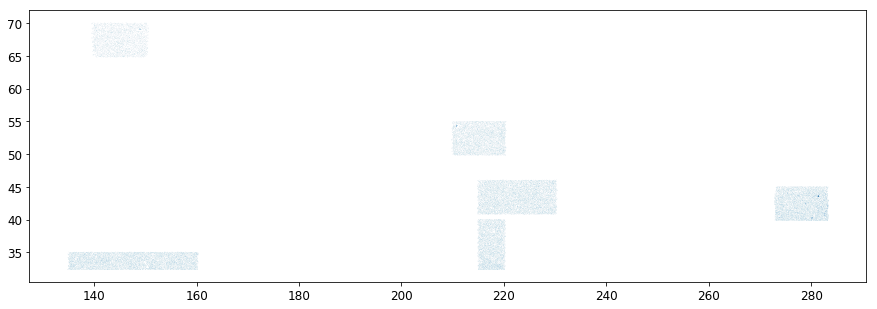

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.1, alpha=0.1)
plt.show()

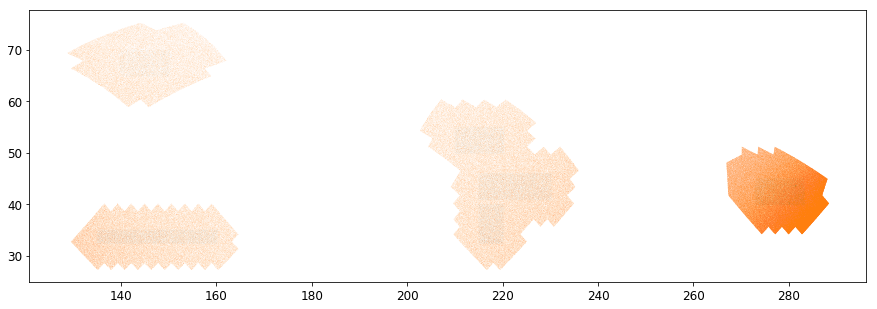

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(cat['RA'][::5], cat['DEC'][::5], '.', ms=0.1, alpha=0.1)
plt.plot(gaia['RA'][::5], gaia['DEC'][::5], '.', ms=0.1, alpha=0.1)
# plt.axis([0, 360, -23, 40])
plt.show()

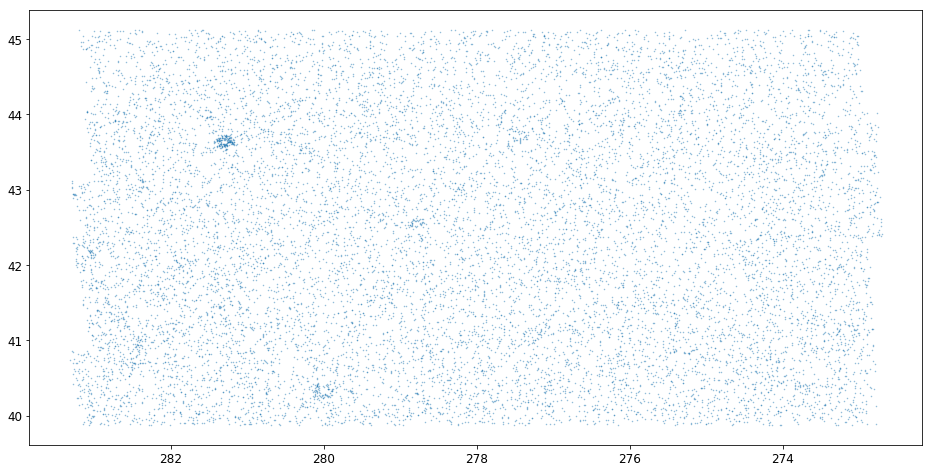

In [30]:
mask = cat['RA']>250
plt.figure(figsize=(16, 8))
plt.plot(cat['RA'][mask], cat['DEC'][mask], '.', ms=1, alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

In [31]:
mask = (gaia['PHOT_G_MEAN_MAG']>16) & (gaia['PHOT_G_MEAN_MAG']<17)
print(np.sum(mask), np.sum(mask)/len(mask))

ra1 = gaia['RA'][mask]
dec1 = gaia['DEC'][mask]
sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')

ra2 = cat['RA']
dec2 = cat['DEC']
sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')

463666 0.108851749339


7270 nearby objects


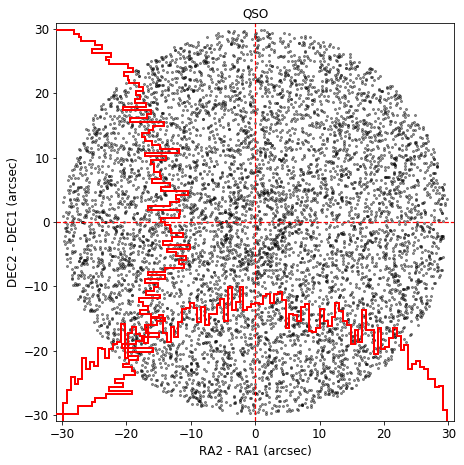

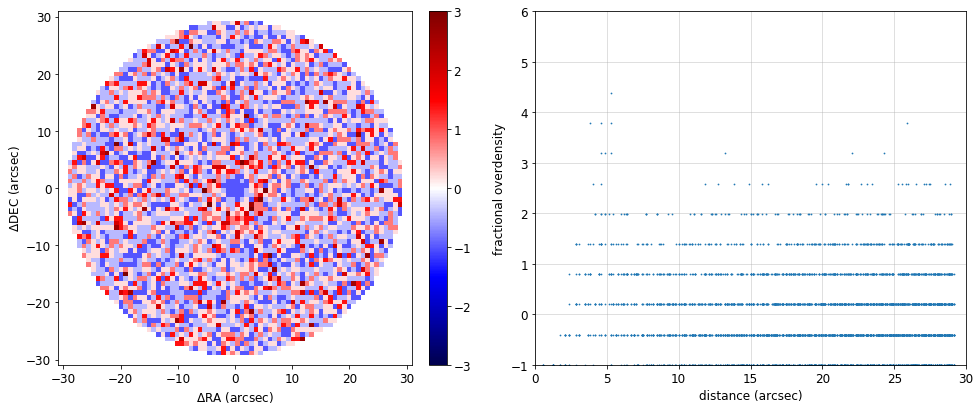

In [32]:
search_radius = 30.
# Paramater for estimating the overdensities
annulus_min = 25.
annulus_max = 30.

nbins = 75

idx1, idx2, d2d, _ = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
print('%d nearby objects'%len(idx1))

# convert distances to numpy array in arcsec
d2d = np.array(d2d.to(u.arcsec))

d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
# Convert d_ra to actual arcsecs
mask = d_ra > 180*3600
d_ra[mask] = d_ra[mask] - 360.*3600
mask = d_ra < -180*3600
d_ra[mask] = d_ra[mask] + 360.*3600
d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)

markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])    
axis = [-search_radius*1.03, search_radius*1.03, -search_radius*1.03, search_radius*1.03]
ax = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, title=target_class, show=False)
plt.show()

ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
ax, bins, mesh_d2d, density_ratio = relative_density_subplots(d_ra, d_dec, d2d, search_radius, ref_density=density_annulus, nbins=nbins)
plt.show()

__More plots!__

In [33]:
gaia_min_list = [-np.inf, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
gaia_max_list = [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
search_radius_list = [500, 350, 300, 250, 200, 150, 120, 90, 60, 30, 30, 30, 30, 30]

147 stars
544 nearby objects


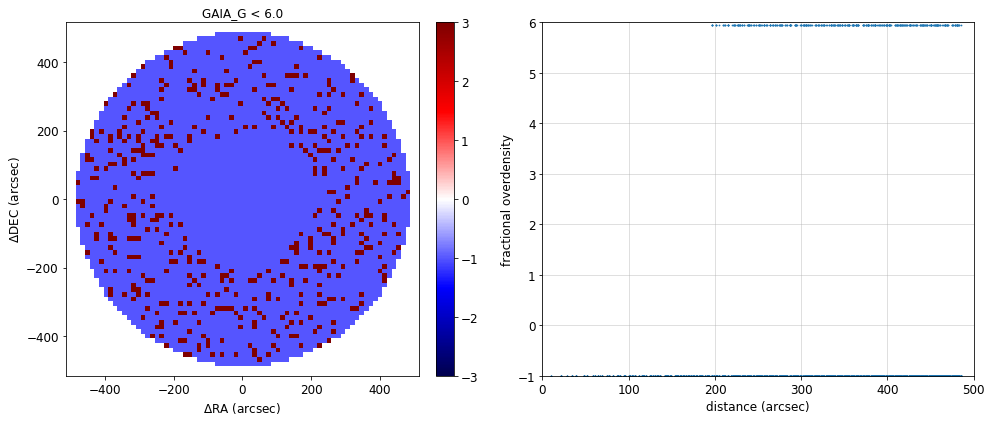

1092 stars
2291 nearby objects


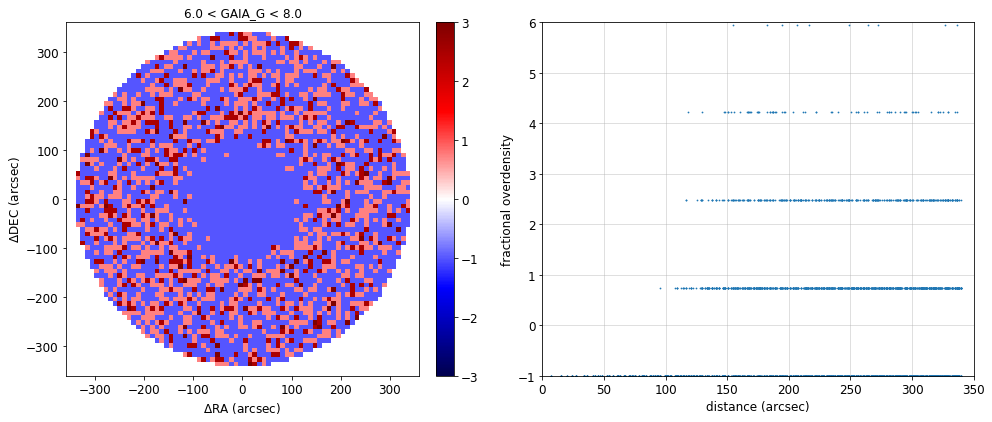

1927 stars
3037 nearby objects


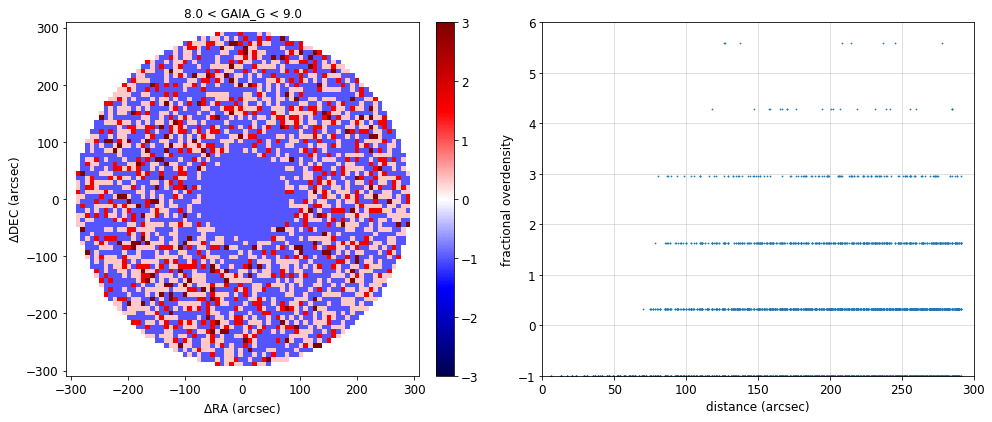

4698 stars
4646 nearby objects


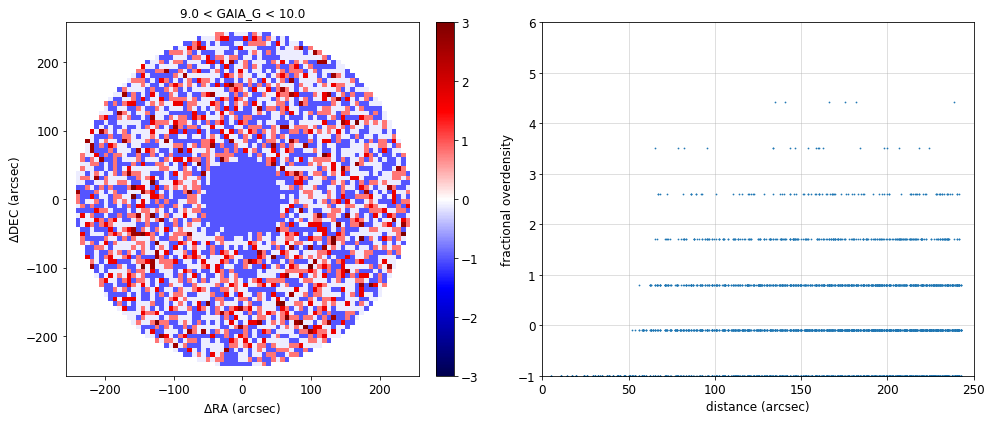

10530 stars
6800 nearby objects


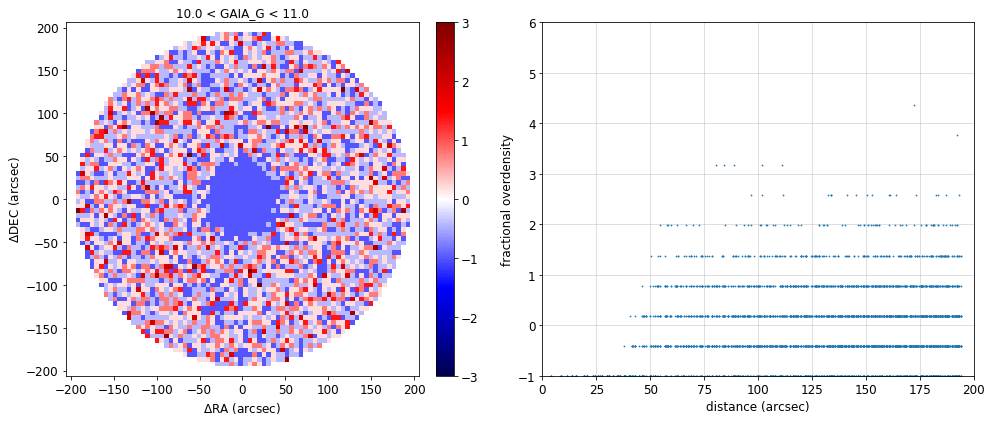

22003 stars
7879 nearby objects


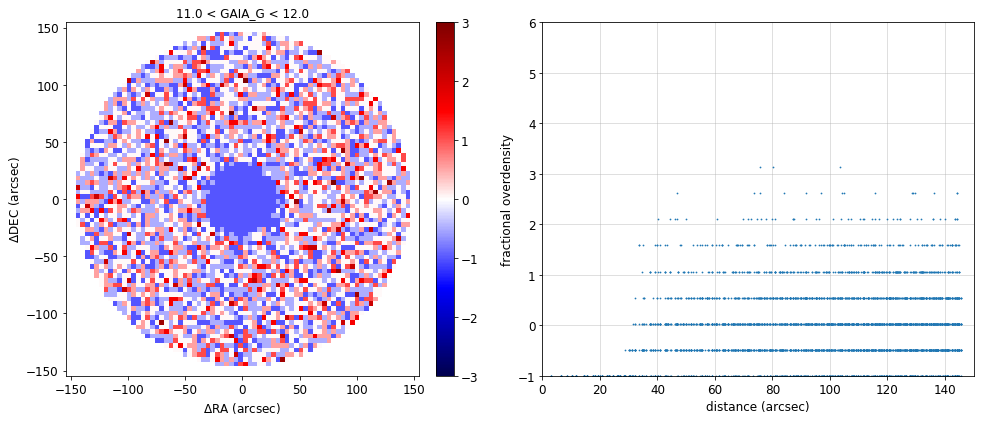

45260 stars
10190 nearby objects


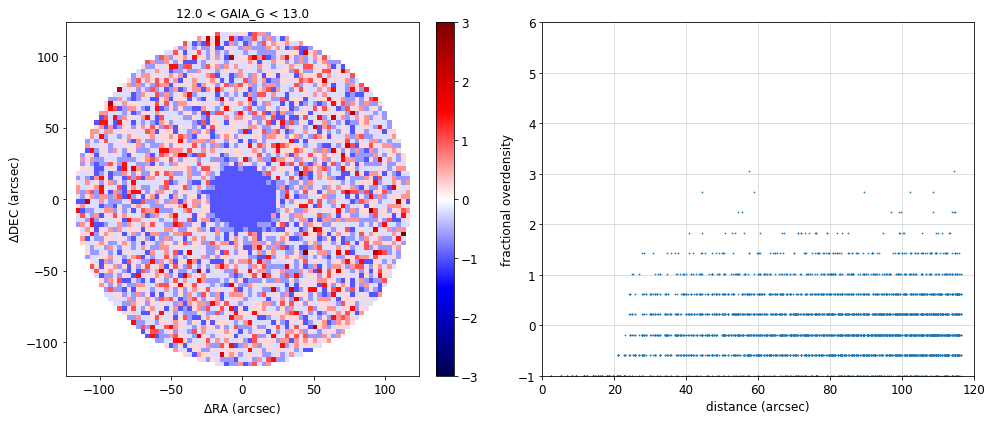

89207 stars
11465 nearby objects


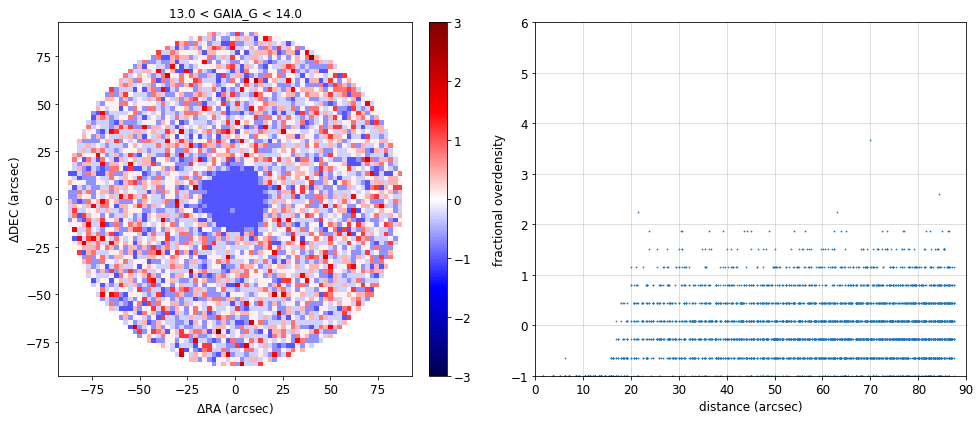

163365 stars
9266 nearby objects


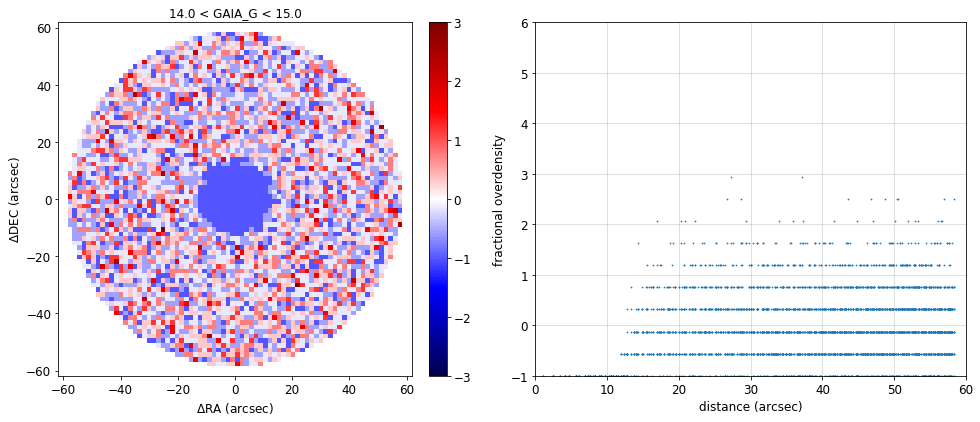

283999 stars
3825 nearby objects


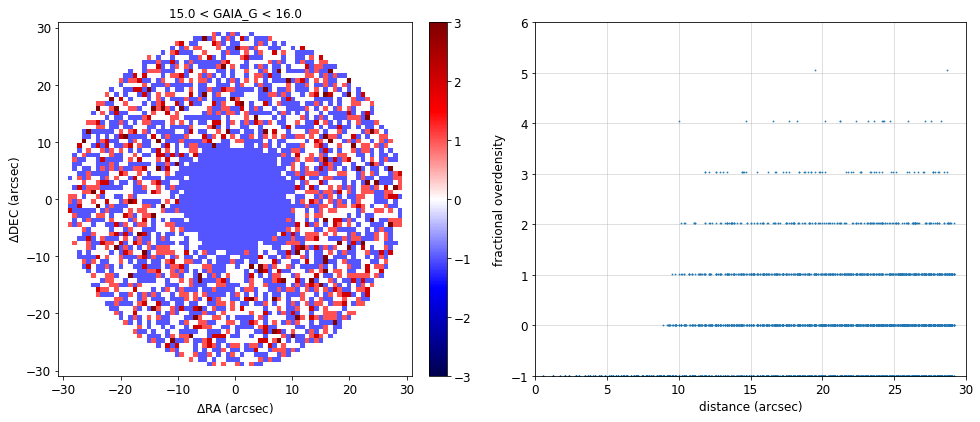

463666 stars
7270 nearby objects


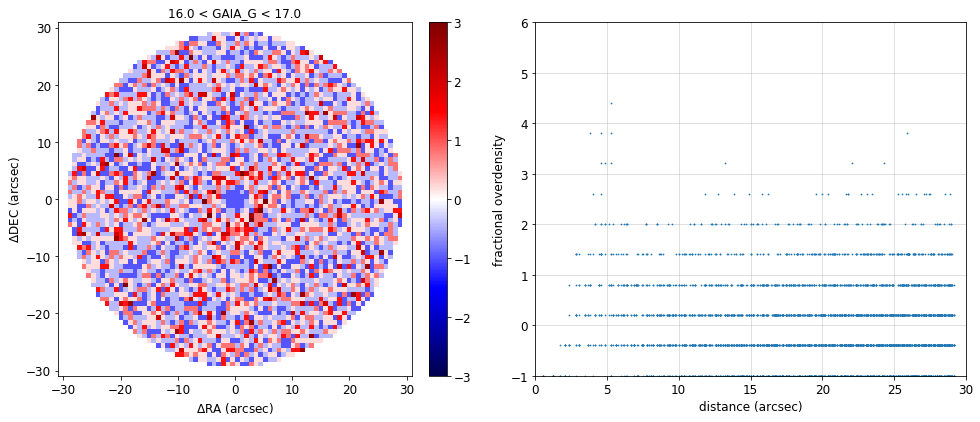

704458 stars
10943 nearby objects


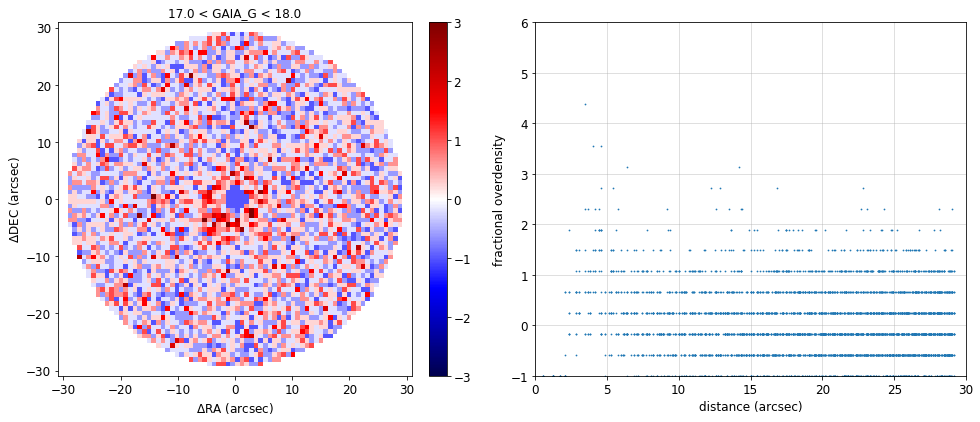

1016367 stars
16911 nearby objects


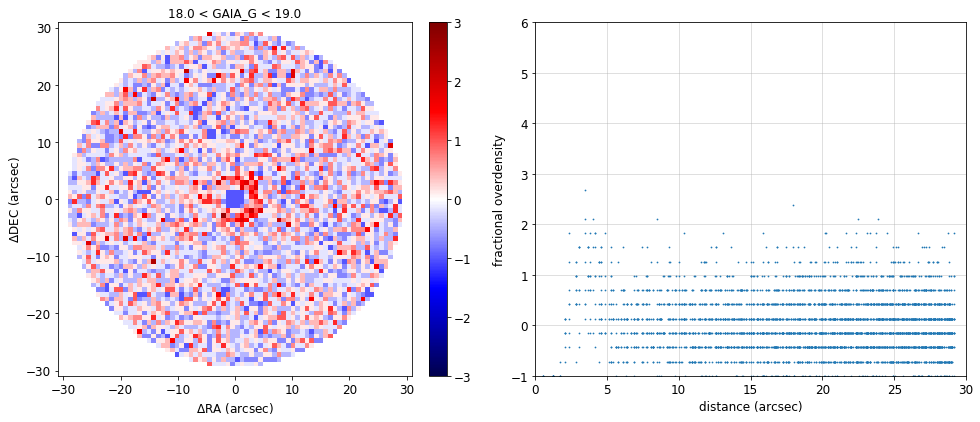

1452884 stars
26765 nearby objects


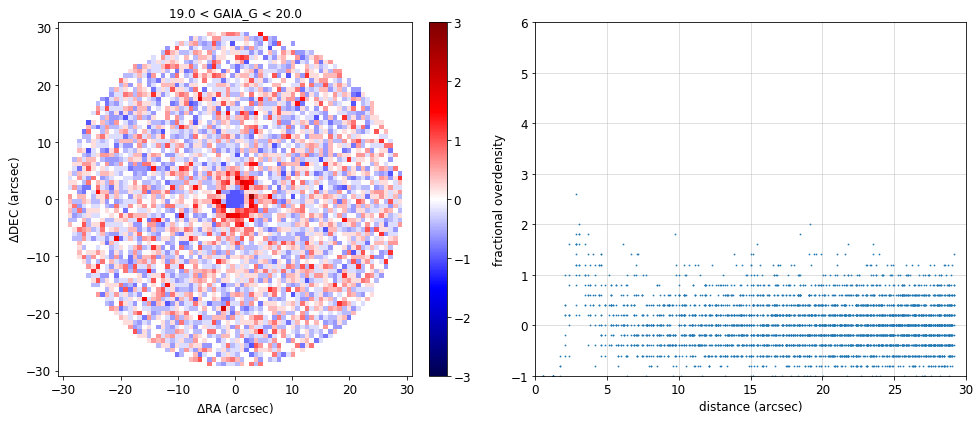

In [34]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('plots/QSO_DR9SV_North.pdf') as pdf:

    for index in range(len(gaia_min_list)):

        nbins = 75
        search_radius = search_radius_list[index]
        axis = [-search_radius*1.03, search_radius*1.03, -search_radius*1.03, search_radius*1.03]

        # Paramater for estimating the overdensities
        annulus_min, annulus_max = search_radius/3.*2, search_radius

        gaia_min, gaia_max = gaia_min_list[index], gaia_max_list[index]
        mask = (gaia['PHOT_G_MEAN_MAG']>gaia_min) & (gaia['PHOT_G_MEAN_MAG']<gaia_max)
        ra1 = gaia['RA'][mask]
        dec1 = gaia['DEC'][mask]
        if gaia_min==-np.inf:
            title = 'GAIA_G < {:.1f}'.format(gaia_max, np.sum(mask))
        else:
            title = '{:.1f} < GAIA_G < {:.1f}'.format(gaia_min, gaia_max, np.sum(mask))

        print('{} stars'.format(np.sum(mask)))

        sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
        idx1, idx2, d2d, _ = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
        print('%d nearby objects'%len(idx1))

        # convert distances to numpy array in arcsec
        d2d = np.array(d2d.to(u.arcsec))

        d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
        d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
        # Convert d_ra to actual arcsecs
        mask = d_ra > 180*3600
        d_ra[mask] = d_ra[mask] - 360.*3600
        mask = d_ra < -180*3600
        d_ra[mask] = d_ra[mask] + 360.*3600
        d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)

        # markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])    
        # ax = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, show=False)
        # ax.set_title(title)
        # plt.show()

        ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
        density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
        ax, bins, mesh_d2d, density_ratio = relative_density_subplots(d_ra, d_dec, d2d, search_radius, ref_density=density_annulus, nbins=nbins)
        ax[0].set_title(title)
        pdf.savefig()
        plt.show()